# Modelagem Avançada e Seleção do Modelo - AMST - Predição de Color EBC

### Contexto e Objetivo

A etapa de modelagem baseline demonstrou que modelos simples e lineares não são suficientes para capturar a complexidade do problema, enquanto um modelo não linear baseado em árvores já apresentou ganhos significativos de desempenho. Esses resultados reforçam as hipóteses levantadas durante a análise exploratória, indicando que a predição da cor (EBC) do mosto depende de interações não lineares entre variáveis de composição e parâmetros térmicos do processo.

O objetivo deste notebook é aprofundar a modelagem preditiva, explorando algoritmos mais robustos e técnicas de otimização de hiperparâmetros com foco em maximizar a performance e a capacidade de generalização do modelo. Nesta etapa, são avaliados modelos baseados em ensembles e boosting, conhecidos por sua eficiência em dados tabulares e por sua habilidade em capturar relações complexas entre variáveis.

Para garantir uma avaliação justa e realista, o mesmo esquema de divisão temporal utilizado na etapa anterior é mantido, assegurando consistência na comparação entre modelos e evitando vazamento de informação. O processo de ajuste fino dos modelos utiliza validação cruzada temporal, refletindo o cenário de uso em produção, no qual previsões são feitas sempre para dados futuros.

Ao final deste notebook, os modelos avaliados são comparados com base em métricas de desempenho e análises gráficas, permitindo a seleção do melhor modelo global. Essa escolha servirá como base para uma análise mais detalhada dos erros e limitações do modelo na etapa seguinte, dedicada à avaliação por faixas do target e à exploração de abordagens complementares para melhoria da predição.


## 1. Imports e Carregamento dos Dados

In [1]:
!pip install xgboost lightgbm -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pathlib import Path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path("/content/drive/MyDrive/heineken_case").resolve()

if not (PROJECT_ROOT / "src").exists():
    raise FileNotFoundError(f"Não achei a pasta src em: {PROJECT_ROOT}")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_PATH = PROJECT_ROOT / "data" / "Heineken - Data Science Use Case 3.csv"
MODEL_PATH = PROJECT_ROOT / "models"

In [4]:
from src.config import RANDOM_STATE, TEST_SIZE, TARGET_COL, Q_LOW, Q_HIGH

from src.data.load_data import load_amst_clean
from src.features.preprocessing import add_domain_features, build_preprocess_pipeline, temporal_train_test_split

from src.models.pipelines import build_xgb_pipeline, build_lgbm_pipeline
from src.models.tuning import tune_random_forest, tune_xgb, tune_lgbm
from src.models.evaluation import eval_regression
from src.models.selection import select_best_model
from src.models.plots import plot_feature_importance

from src.models.io import save_model

## 2. Carregar e preparar os dados (limpeza + features)

In [5]:
# Carregando os dados brutos
df = pd.read_csv(DATA_PATH)
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M", errors="coerce")

# Foco no produto AMST (escopo do case)
df_amst = df[df["Product"] == "AMST"].copy()
print("Dimensão AMST (bruto):", df_amst.shape)

# Regras de limpeza:
# - remover linhas sem target
# - remover Color < 0 (fisicamente impossível)
df_amst = df_amst[df_amst["Color"].notna()]
df_amst = df_amst[df_amst["Color"] >= 0]

# Ordenar temporalmente (importante para split de série temporal)
df_amst = df_amst.sort_values("Date/Time")

print("Dimensão AMST após limpeza:", df_amst.shape)

Dimensão AMST (bruto): (460, 22)
Dimensão AMST após limpeza: (427, 22)


In [6]:
# Feature engineering
df_amst["total_malt"] = (
    df_amst["Roast amount (kg)"]
    + df_amst["1st malt amount (kg)"]
    + df_amst["2nd malt amount (kg)"]
)

df_amst["roast_pct"] = np.where(
    df_amst["total_malt"] > 0,
    df_amst["Roast amount (kg)"] / df_amst["total_malt"],
    0.0
)

df_amst["mt_energy"] = df_amst["MT - Temperature"] * df_amst["MT - Time"]
df_amst["wk_energy"] = df_amst["WK - Temperature"] * df_amst["WK - Time"]

# Definir colunas a descartar como features
drop_cols = ["Unnamed: 0", "Product", "Job ID", "Date/Time"]

feature_cols = [
    c for c in df_amst.columns
    if c not in drop_cols + ["Color"]
]

print("Total de features:", len(feature_cols))
feature_cols

Total de features: 21


['Roast amount (kg)',
 '1st malt amount (kg)',
 '2nd malt amount (kg)',
 'MT - Temperature',
 'MT - Time',
 'WK - Temperature',
 'WK - Steam',
 'WK - Time',
 'Total cold wort',
 'pH',
 'Extract',
 'WOC - Time',
 'WHP Transfer - Time',
 'WHP Rest - Time',
 'Roast color',
 '1st malt color',
 '2nd malt color',
 'total_malt',
 'roast_pct',
 'mt_energy',
 'wk_energy']

## 3. Split temporal treino / teste

In [7]:
n_rows = df_amst.shape[0]
split_idx = int(n_rows * (1 - TEST_SIZE))

train = df_amst.iloc[:split_idx]
test  = df_amst.iloc[split_idx:]

X_train = train[feature_cols]
y_train = train["Color"]

X_test  = test[feature_cols]
y_test  = test["Color"]

print("Total linhas:", n_rows)
print("Treino:", X_train.shape[0], "| Teste:", X_test.shape[0])
print("Período treino: ", train["Date/Time"].min(), "→", train["Date/Time"].max())
print("Período teste : ", test["Date/Time"].min(),  "→", test["Date/Time"].max())

Total linhas: 427
Treino: 341 | Teste: 86
Período treino:  2020-10-22 02:50:00 → 2020-11-27 23:01:00
Período teste :  2020-11-27 23:16:00 → 2020-11-30 03:16:00


## 4. Pipeline de pré-processamento

In [8]:
preprocess = build_preprocess_pipeline(feature_cols)
preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Roast amount (kg)', '1st malt amount (kg)',
                                  '2nd malt amount (kg)', 'MT - Temperature',
                                  'MT - Time', 'WK - Temperature', 'WK - Steam',
                                  'WK - Time', 'Total cold wort', 'pH',
                                  'Extract', 'WOC - Time',
                                  'WHP Transfer - Time', 'WHP Rest - Time',
                                  'Roast color', '1st malt color',
                                  '2nd malt color', 'total_malt', 'roast_pct',
                                  'mt_energy', 'wk_energy'])])

## 5. Treinar todos os modelos

### 5.1 Random Forest (tuning com RandomizedSearchCV)

In [9]:
rf_search = tune_random_forest(
    X_train, y_train, preprocess,
    random_state=RANDOM_STATE,
    n_iter=25  # ajuste conforme tempo disponível
)
best_rf_model = rf_search.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)
rf_metrics = eval_regression(y_test, y_pred_rf, label="RandomForest (tuned)")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Melhores hiperparâmetros RF: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': 15}
Melhor RMSE (CV): 9.896848567333754
RandomForest (tuned)      -> MAE:  6.750 | RMSE:  8.617 | R²:  0.040


### 5.2 XGBoost (tuning)

In [10]:
xgb_search = tune_xgb(
    X_train, y_train, preprocess,
    random_state=RANDOM_STATE,
    n_iter=25
)
best_xgb_model = xgb_search.best_estimator_

y_pred_xgb = best_xgb_model.predict(X_test)
xgb_metrics = eval_regression(y_test, y_pred_xgb, label="XGBoost (tuned)")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Melhores hiperparâmetros XGB: {'model__subsample': 0.7, 'model__n_estimators': 200, 'model__min_child_weight': 5, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.7}
Melhor RMSE (CV): 10.152143356680227
XGBoost (tuned)           -> MAE:  6.896 | RMSE:  8.729 | R²:  0.015


### 5.3 LightGBM (tuning)

In [13]:
lgbm_search = tune_lgbm(
    X_train, y_train, preprocess,
    random_state=RANDOM_STATE,
    n_iter=25,
    verbose=0
)
best_lgbm_model = lgbm_search.best_estimator_

y_pred_lgbm = best_lgbm_model.predict(X_test)
lgbm_metrics = eval_regression(y_test, y_pred_lgbm, label="LightGBM (tuned)")

Melhores hiperparâmetros LGBM: {'model__subsample': 0.8, 'model__num_leaves': 63, 'model__n_estimators': 400, 'model__min_child_samples': 10, 'model__max_depth': 4, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.7}
Melhor RMSE (CV): 10.429467726478359
LightGBM (tuned)          -> MAE:  7.020 | RMSE:  8.919 | R²: -0.028


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## 6. Tabela comparativa de resultados

In [14]:
results = {}

results["rf_tuned"]   = rf_metrics
results["xgb_tuned"]  = xgb_metrics
results["lgbm_tuned"] = lgbm_metrics

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("rmse")
results_df

,mae,rmse,r2
rf_tuned,6.749512,8.616805,0.040259
xgb_tuned,6.896226,8.729162,0.015067
lgbm_tuned,7.019708,8.919017,-0.028242


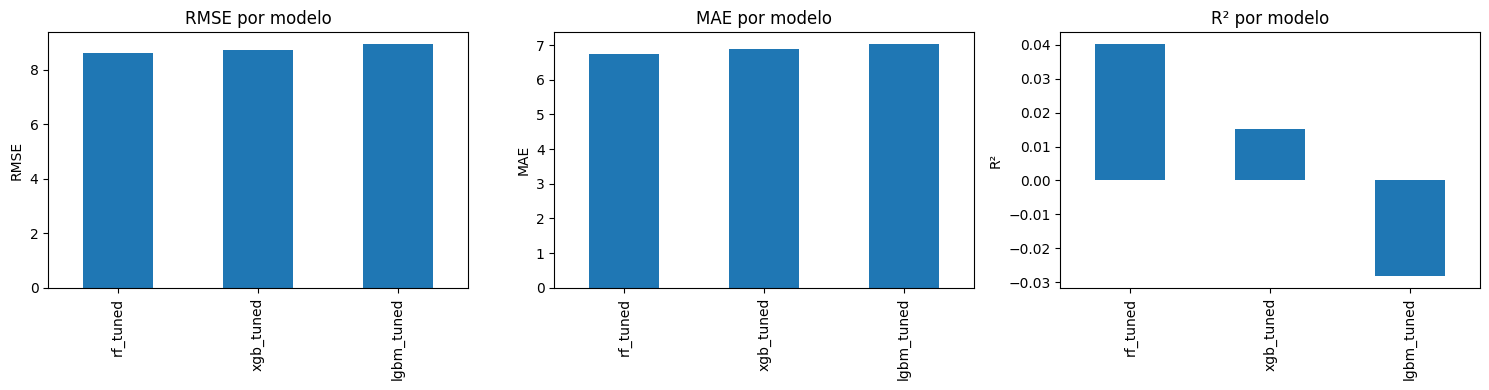

In [15]:
# Gráfico comparando RMSE, MAE, R²
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

results_df["rmse"].plot(kind="bar", ax=axes[0], title="RMSE por modelo")
axes[0].set_ylabel("RMSE")

results_df["mae"].plot(kind="bar", ax=axes[1], title="MAE por modelo")
axes[1].set_ylabel("MAE")

results_df["r2"].plot(kind="bar", ax=axes[2], title="R² por modelo")
axes[2].set_ylabel("R²")

plt.tight_layout()
plt.show()


## 7. Escolha do melhor modelo e salvamento

In [16]:
models = {}

models["rf_tuned"] = best_rf_model
models["xgb_tuned"] = best_xgb_model
models["lgbm_tuned"] = best_lgbm_model

In [17]:
best_model_name = select_best_model(results_df, metric="rmse")
print("Melhor modelo:", best_model_name)

best_model = models[best_model_name]

# salvar o modelo final
model_save_path = os.path.join(MODEL_PATH, "best_model.joblib")
save_model(best_model, model_save_path)

Melhor modelo: rf_tuned
Modelo salvo em: /content/drive/MyDrive/heineken_case/models/best_model.joblib


## 8. Visualização gráfica para o melhor modelo

### 8.1 y_true vs y_pred (dispersão)

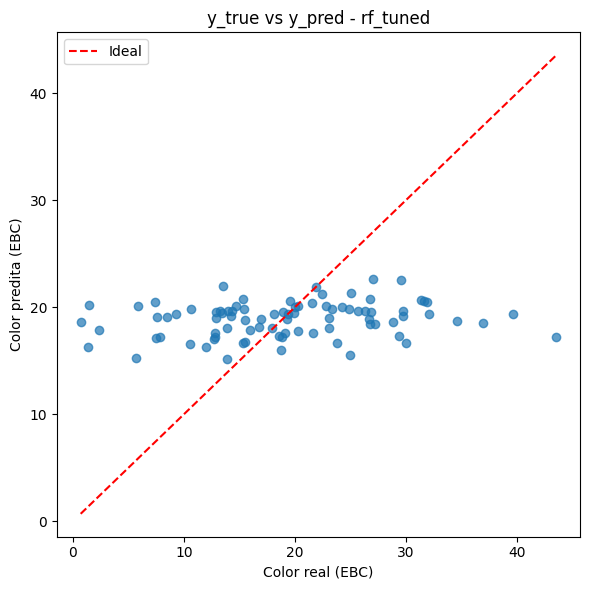

In [18]:
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
max_val = max(y_test.max(), y_pred_best.max())
min_val = min(y_test.min(), y_pred_best.min())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal")
plt.xlabel("Color real (EBC)")
plt.ylabel("Color predita (EBC)")
plt.title(f"y_true vs y_pred - {best_model_name}")
plt.legend()
plt.tight_layout()
plt.show()

Se os pontos estiverem próximos da linha vermelha, o modelo está prevendo bem.
Desvios sistemáticos (faixas acima/abaixo) indicam bias.

### 8.2 Série temporal: real vs previsto no tempo

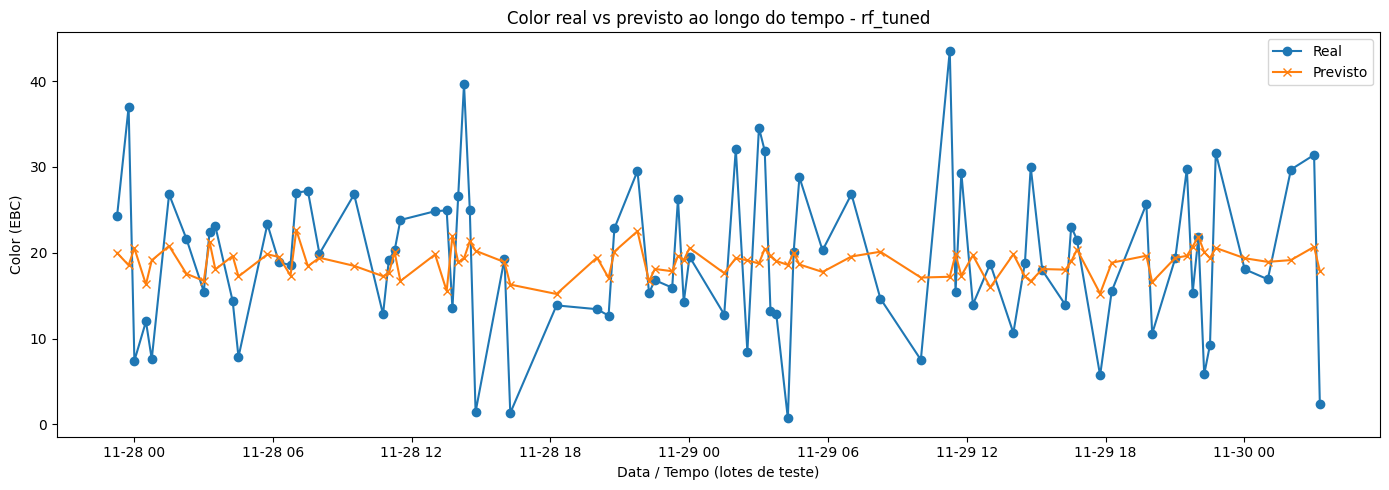

In [19]:
test_with_pred = test.copy()
test_with_pred["Color_pred"] = y_pred_best

plt.figure(figsize=(14,5))
plt.plot(test_with_pred["Date/Time"], test_with_pred["Color"], label="Real", marker="o")
plt.plot(test_with_pred["Date/Time"], test_with_pred["Color_pred"], label="Previsto", marker="x")
plt.xlabel("Data / Tempo (lotes de teste)")
plt.ylabel("Color (EBC)")
plt.title(f"Color real vs previsto ao longo do tempo - {best_model_name}")
plt.legend()
plt.tight_layout()
plt.show()

### 8.3 Distribuição dos resíduos

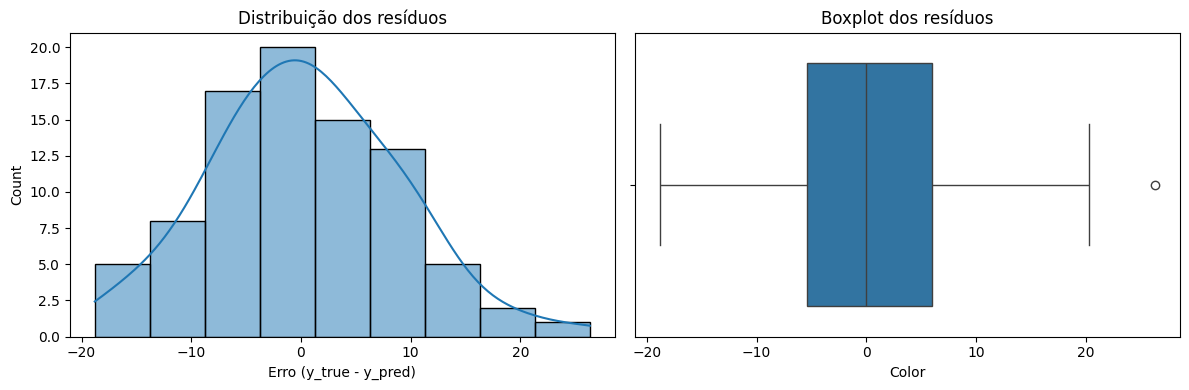

In [20]:
residuals = y_test - y_pred_best

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(residuals, kde=True)
plt.title("Distribuição dos resíduos")
plt.xlabel("Erro (y_true - y_pred)")

plt.subplot(1,2,2)
sns.boxplot(x=residuals)
plt.title("Boxplot dos resíduos")

plt.tight_layout()
plt.show()

Se os resíduos estiverem centrados em zero e relativamente simétricos → bom sinal.

Caudas muito grandes podem indicar casos específicos a investigar.

### 8.4 Resíduos vs predições

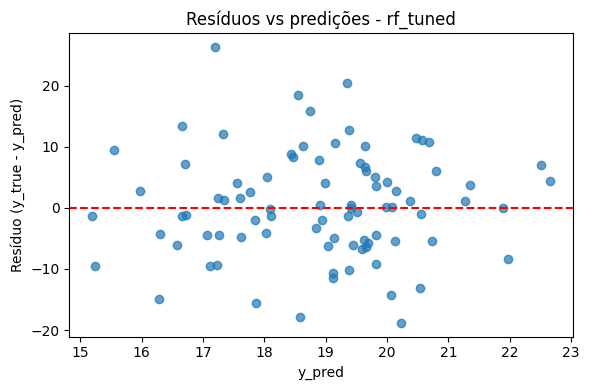

In [21]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred_best, residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("y_pred")
plt.ylabel("Resíduo (y_true - y_pred)")
plt.title(f"Resíduos vs predições - {best_model_name}")
plt.tight_layout()
plt.show()

### 8.5 Importância de features

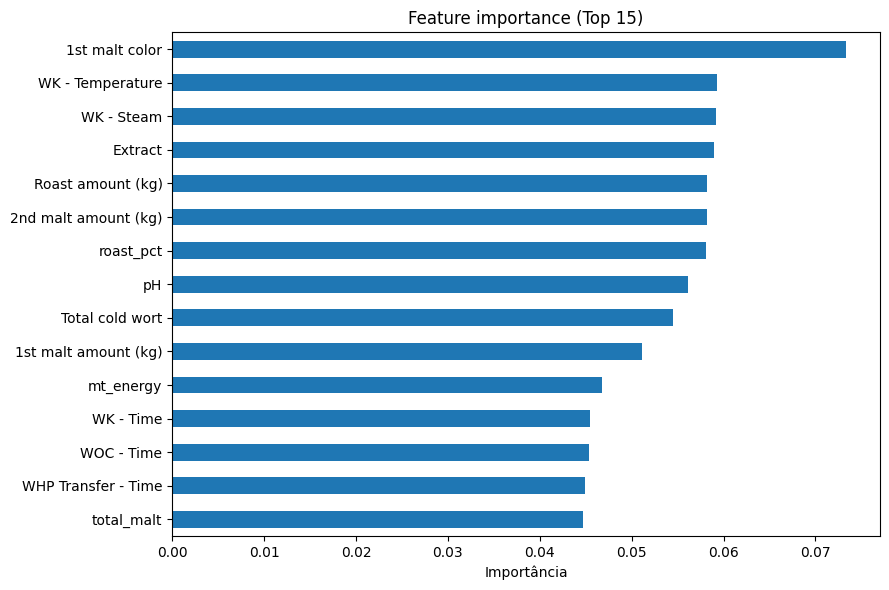

In [22]:
plot_feature_importance(best_model, feature_cols, top_n=15)

## 9. Resumo da Modelagem e Avaliação

Este estudo teve como objetivo desenvolver um modelo preditivo para estimar a cor (EBC) do mosto frio do produto AMST, utilizando variáveis relacionadas à composição de maltes, parâmetros térmicos do processo e propriedades físico-químicas medidas durante a produção.

A análise exploratória dos dados evidenciou que o problema apresenta forte caráter não linear e depende de interações complexas entre variáveis, especialmente associadas à proporção de maltes utilizados e à energia térmica aplicada nas etapas de cozimento. Esses achados orientaram a escolha de modelos capazes de capturar relações não lineares e efeitos combinados entre variáveis.

Na etapa de modelagem, modelos lineares e não lineares foram avaliados de forma incremental. Modelos lineares apresentaram desempenho limitado, enquanto abordagens baseadas em árvores demonstraram ganhos significativos, confirmando as hipóteses levantadas durante o EDA. A partir desse ponto, técnicas de ajuste fino de hiperparâmetros e algoritmos de boosting foram explorados com o objetivo de maximizar a performance e a capacidade de generalização do modelo.

O Random Forest com hiperparâmetros otimizados apresentou o melhor desempenho global, sobretudo na faixa central de cor, que concentra a maior parte da produção. O modelo demonstrou boa estabilidade temporal, ausência de viés sistemático relevante e coerência entre as variáveis mais importantes e o conhecimento físico-químico do processo cervejeiro, reforçando sua adequação para uso operacional.

A análise detalhada por faixas de cor revelou que abordagens adicionais, como o uso de ponderação de amostras em modelos de boosting, podem proporcionar melhorias pontuais na predição de valores extremos do target. No entanto, esses ganhos ocorrem à custa de perda de desempenho na faixa central, evidenciando um trade-off clássico entre robustez global e sensibilidade a regiões raras do espaço de dados.

Dessa forma, o Random Forest otimizado foi mantido como modelo principal, por oferecer o melhor equilíbrio entre precisão, estabilidade e robustez operacional. Modelos ponderados ou especializados podem ser utilizados de forma complementar, especialmente como ferramentas de suporte à análise de lotes extremos em cenários onde desvios de cor representam maior risco ao processo produtivo.

Como próximos passos, recomenda-se:
- a ampliação da base de dados, com foco em observações nas regiões extremas do target;
- o refinamento contínuo de features baseadas em princípios físicos do processo;
- a implementação de monitoramento do modelo em produção, incluindo o acompanhamento de drift de dados e de performance ao longo do tempo.
